In [8]:
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge


In [9]:
class Config:
    dataset_size = 5000
    n_hidden_layers = 3    # Number of hidden layers
    width = 5              # Size of mlp's hidden layer
    lr = 1e-3              # Learning rate
    weight_deacy=0         # l2 regularization
    batch_size = 256       # Batch size
    n_epochs = 1000        # Number of epochs
    device = "cpu"         # "cuda:0" or "cpu"
    input_dim=20           # input dimensioanlity

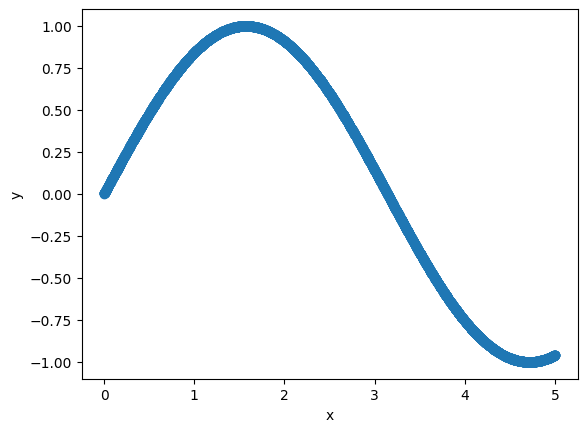

In [10]:
device = torch.device(Config.device if torch.cuda.is_available() else "cpu")

X = 5 * np.random.rand(Config.dataset_size, Config.input_dim)
y = np.sin(X[:,2]**1).ravel()

plt.figure()
plt.scatter(X[:,2], y )
plt.xlabel('x'); plt.ylabel('y')
plt.show()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


In [11]:
def get_mlp(InputDim=1,LatentDim=50,OutputDim=1,Depth=3,UseBias=True):
    activation_to_use=nn.LeakyReLU()
    layers=nn.ModuleList([nn.Linear(InputDim, LatentDim, bias=UseBias)])
    layers.append(activation_to_use)
    for d in range(Depth):
        layers.append(nn.Linear(LatentDim, LatentDim, bias=UseBias))
        layers.append(activation_to_use)
    layers.append( nn.Linear(LatentDim, OutputDim, bias=UseBias))
    return nn.Sequential(*layers)

class KerAttModel(nn.Module):
     def __init__(self, InputDim=10, OutputDim=1, AttDim=5, ValueDim=5,MlpDepth=3):
         super(KerAttModel, self).__init__()
         # self.key =  get_mlp(InputDim=InputDim+OutputDim,OutputDim=AttDim,Depth=MlpDepth)
         # self.query = get_mlp(InputDim=InputDim,OutputDim=AttDim,Depth=MlpDepth)
         # self.value = get_mlp(InputDim=InputDim+OutputDim,OutputDim=ValueDim,Depth=MlpDepth)
         # self.ff = get_mlp(InputDim=ValueDim, OutputDim=OutputDim,Depth=MlpDepth)

         self.key =  get_mlp(InputDim=InputDim,OutputDim=AttDim,Depth=MlpDepth)
         self.query = get_mlp(InputDim=InputDim,OutputDim=AttDim,Depth=MlpDepth)
         self.value = get_mlp(InputDim=OutputDim,OutputDim=ValueDim,Depth=MlpDepth)
         self.ff = get_mlp(InputDim=ValueDim, OutputDim=OutputDim,Depth=MlpDepth)

     def forward(self, x_ref, y_ref, x):
         # K = self.key(torch.cat((x_ref,y_ref), dim=1))
         # Q = self.query(x)
         # V = self.value(torch.cat((x_ref,y_ref), dim=1))

         K = self.key(x_ref)
         Q = self.query(x)
         V = self.value(y_ref)

         K=F.normalize(K, p=2, dim=1)
         Q=F.normalize(Q, p=2, dim=1)

         A = nn.Softmax(dim=0)(K @ Q.T)
         pred = self.ff(A.T @ V)
         return pred

In [12]:
net = get_mlp(InputDim=Config.input_dim,LatentDim=5,OutputDim=1,Depth=Config.n_hidden_layers,UseBias=True).to(device)
# net=MlpModel(din=10, dout=1)
net = KerAttModel(InputDim=Config.input_dim, OutputDim=1, AttDim=5, ValueDim=5,MlpDepth=Config.n_hidden_layers)
self=net

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=Config.lr, weight_decay=Config.weight_deacy)

training_data=list(zip(X_train.astype('float32',casting='same_kind'),
                       y_train.astype('float32',casting='same_kind').reshape(-1,1)))
train_dataloader = DataLoader(training_data, batch_size=Config.batch_size, shuffle=True)
val_data=list(zip(X_test.astype('float32',casting='same_kind'),
                  y_test.astype('float32',casting='same_kind').reshape(-1,1)))
val_dataloader = DataLoader(val_data, batch_size=Config.batch_size, shuffle=True)

TrainLosses=[]
ValLosses=[]
pbar= tqdm(range(Config.n_epochs))
for ind in pbar:
    optimizer.zero_grad()
    x_ref, y_ref = next(iter(train_dataloader))
    x, y = next(iter(train_dataloader))
    pred = net(x_ref, y_ref, x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    TrainLosses.append(loss.item())

    with torch.no_grad():
        x, y = next(iter(val_dataloader))
        pred = net(x_ref, y_ref, x)
        loss = criterion(pred, y)
        ValLosses.append(loss.item())

    pbar.set_description('TrainLoss:%.3g, ValSourceLoss:%.3g'%(TrainLosses[-1],ValLosses[-1]))


TrainLoss:0.0112, ValSourceLoss:0.00944: 100%|██████████| 1000/1000 [00:35<00:00, 28.50it/s]


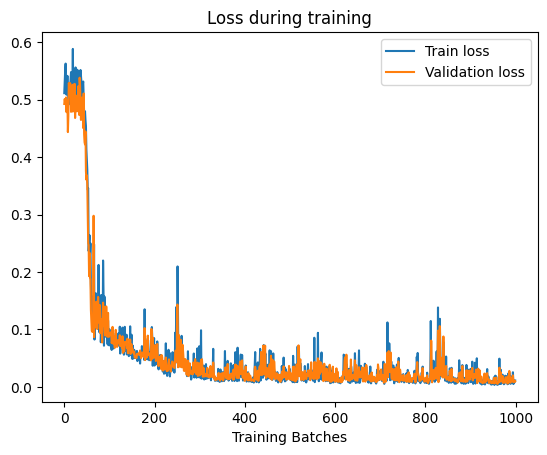

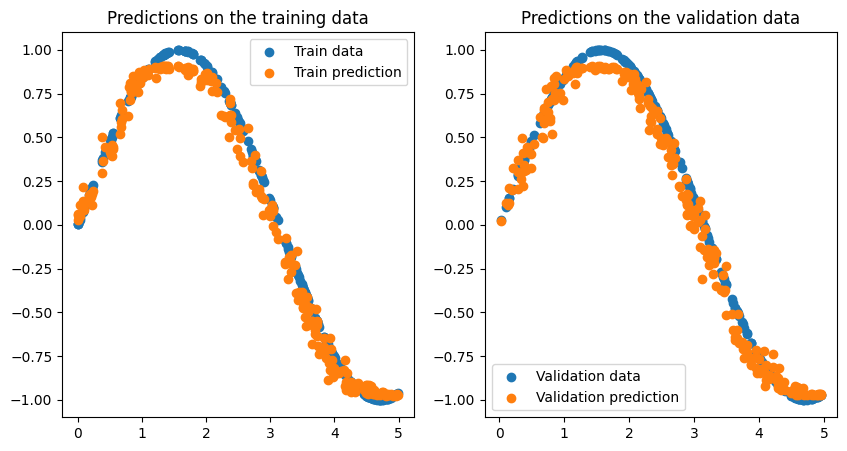

In [13]:
plt.figure()
plt.plot(TrainLosses,label='Train loss')
plt.plot(ValLosses,label='Validation loss')
plt.xlabel('Training Batches')
plt.legend()
plt.title('Loss during training')
plt.show()

x_ref, y_ref = next(iter(train_dataloader))
x, y = next(iter(train_dataloader))
x_val, y_val = next(iter(val_dataloader))

pred_train = net(x_ref, y_ref, x)
pred_val = net(x_ref, y_ref, x_val)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(x.detach().cpu()[:,2],y.detach().cpu(),label='Train data')
plt.scatter(x.detach().cpu()[:,2], pred_train.detach().cpu(),label='Train prediction')
plt.title('Predictions on the training data')
plt.legend()
plt.subplot(122)
plt.scatter(x_val.detach().cpu()[:,2],y_val.detach().cpu(),label='Validation data')
plt.scatter(x_val.detach().cpu()[:,2], pred_val.detach().cpu(),label='Validation prediction')
plt.title('Predictions on the validation data')
plt.legend()
plt.show()

In [14]:
#perform grid search
kr_grid_search = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})
x_ref, y_ref = next(iter(train_dataloader))
kr_grid_search.fit(x_ref, y_ref)

#train full model using the selected hyperparameters
kr =KernelRidge(kernel="rbf", **kr_grid_search.best_params_)
kr.fit(X_train,y_train)
y_kr = kr.predict(x_val)



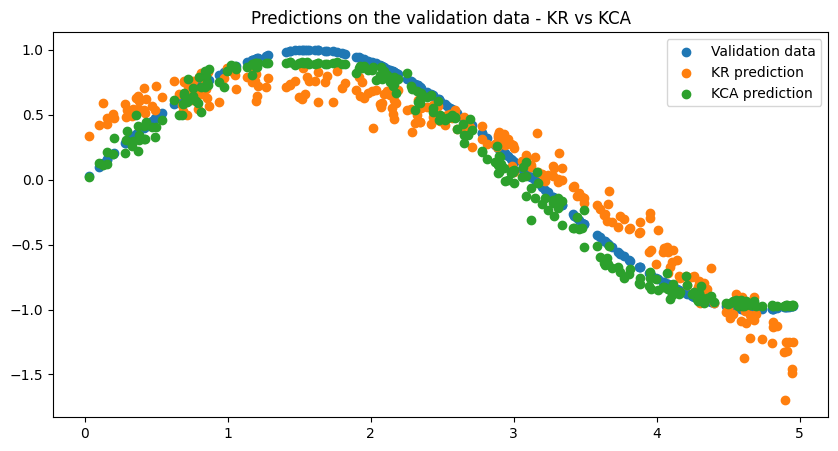

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(x_val.detach().cpu()[:,2],y_val.detach().cpu(),label='Validation data')
plt.scatter(x_val.detach().cpu()[:,2], y_kr,label='KR prediction')
plt.scatter(x_val.detach().cpu()[:,2], pred_val.detach().cpu(),label='KCA prediction')
plt.legend()
plt.title('Predictions on the validation data - KR vs KCA')
plt.show()
